# 1 Prerequisites

In [2]:
import gdown
from pickle import dump, load
import shutil
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [3]:
np.random.seed(33)
tf.random.set_seed(33)

## 1.1 Required global functions

In [4]:
def download_from_drive(filename, file_id):
    url = f"https://drive.google.com/uc?export=download&id={file_id}"
    gdown.download(url, filename, quiet=False)

def load_dataset(image_size=(150, 150)):

    categories = ["NORMAL", "COVID"]
    datasets_name_list = ["test", "train"]
    X = [[], []] # 0 for test & 1 for train
    y = [[], []] # 0 for test & 1 for train

    for i, dataset_name in enumerate(datasets_name_list):
        for label, category in enumerate(categories):
            dir_path = "/kaggle/working/dataset1/" + dataset_name + '/' + category + '/'
            for filename in os.listdir(dir_path):
                img_path = os.path.join(dir_path, filename)
                img = Image.open(img_path).convert("RGB")
                img = img.resize(image_size)
                img_array = np.array(img)
                X[i].append(img_array)
                y[i].append(label) # NORMAL = 0, COVID = 1

    X_train = np.array(X[1]) / 255.0
    y_train = np.array(y[1])
    X_test = np.array(X[0]) / 255.0
    y_test = np.array(y[0])

    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    return X_train, y_train, X_test, y_test
        

## 1.2 Downloading & Loading the dataset

In [7]:
download_from_drive(
    filename="Datasets.rar",
    file_id="1wM1NufVrRtbHuLmeBjiOls_e80Qrsoy-"
)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wM1NufVrRtbHuLmeBjiOls_e80Qrsoy-
From (redirected): https://drive.google.com/uc?export=download&id=1wM1NufVrRtbHuLmeBjiOls_e80Qrsoy-&confirm=t&uuid=4c6dd7af-157c-41c9-bdd4-0caa4dc59bae
To: /kaggle/working/Datasets.rar
100%|██████████| 220M/220M [00:02<00:00, 81.0MB/s] 


In [8]:
# Extract the Datasets.rar file in the current directory
!unrar x "Datasets.rar" ./


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from Datasets.rar

Creating    ./dataset2                                                OK
Creating    ./dataset2/test                                           OK
Creating    ./dataset2/test/NORMAL                                    OK
Extracting  ./dataset2/test/NORMAL/NORMAL(1266).jpg                      0  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1267).jpg                      0  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1268).jpg                      0  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1269).jpg                      1  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1270).jpg                      1  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1271).jpg                      1  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1272).jpg                      2  OK 
Extracting  ./dataset2/test/NORMAL/NORMAL(1273).jpg                      2  OK 
Extracting  ./dataset2/test/NORMAL/

In [5]:
X_train, y_train, X_test, y_test = load_dataset()

In [6]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_covid = sum(y_train[y_train==1]) + sum(y_test[y_test==1])
print(f"Number of Training Samples: {num_train}\nNumber of Test Samples: {num_test}\nNumber of COVID samples: {num_covid}\nNumber of Normal samples: {num_train + num_test - num_covid}")

Number of Training Samples: 148
Number of Test Samples: 40
Number of COVID samples: 94
Number of Normal samples: 94


## 1.3 CNN Architecture

In [7]:
def define_model(input_shape=(150,150,3), lr=0.001):
    model = Sequential(
        [
            # Input
            Input(shape=input_shape),
            
            # Conv1
            Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
            BatchNormalization(axis=-1),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.2),

            # Conv2
            Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
            BatchNormalization(axis=-1),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.2),

            # Conv3
            Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
            BatchNormalization(axis=-1),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.2),

            # Conv4
            Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
            BatchNormalization(axis=-1),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.2),

            # Conv5
            Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
            BatchNormalization(axis=-1),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.2),

            # Conv6
            Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
            BatchNormalization(axis=-1),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.2),

            # Flatten Layer
            Flatten(),

            # FCL
            Dense(512, activation='relu'),
            BatchNormalization(axis=-1),
            Dense(256, activation='relu'),
            BatchNormalization(axis=-1),

            # Output
            Dense(1, activation='sigmoid')
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## 1.4 Train & Evaluation of model with k-fold cross-validation

In [8]:
def train_evaluate_model_with_k_fold(X_train, y_train, lr=0.01, epochs=50, batch_size=16, output_model=False):
    
    kf = KFold(n_splits=10, shuffle=True, random_state=33)

    fold_no = 1
    train_acc_scores = []
    val_acc_scores = []
    
    for train_index, val_index in kf.split(X_train, y_train):
        print(f"\nTraining on Fold {fold_no}...")
        
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        # Recreate a fresh model for each fold
        model = define_model(input_shape=(150,150,3), lr=lr)
        
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
            ],
            verbose=1,
            shuffle=True
        )
        
        # Evaluate the model on the fold's training and validation sets
        train_loss, train_acc = model.evaluate(X_tr, y_tr, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        
        print(f"Fold {fold_no} - Train Accuracy: {train_acc*100:.2f}%, Validation Accuracy: {val_acc*100:.2f}%")
        train_acc_scores.append(train_acc)
        val_acc_scores.append(val_acc)
        
        fold_no += 1
    
    print("\nAverage Training Accuracy: {:.2f}%".format(np.mean(train_acc_scores)*100))
    print("Average Validation Accuracy: {:.2f}%".format(np.mean(val_acc_scores)*100))

    if output_model:
        return model

# 2 Data Collection and Image Preprocessing

## 2.0 Evaluation before adding augmented dataset

In [91]:
train_evaluate_model_with_k_fold(X_train, y_train, lr=0.01, epochs=50, batch_size=16)


Training on Fold 1...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 885ms/step - accuracy: 0.6716 - loss: 1.1087 - val_accuracy: 0.4667 - val_loss: 12465.7129 - learning_rate: 0.0100
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8765 - loss: 0.4161 - val_accuracy: 0.4667 - val_loss: 883.4987 - learning_rate: 0.0100
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9377 - loss: 0.1560 - val_accuracy: 0.4667 - val_loss: 1059.7609 - learning_rate: 0.0100
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9854 - loss: 0.0820 - val_accuracy: 0.4667 - val_loss: 206.0867 - learning_rate: 0.0100
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9867 - loss: 0.0418 - val_accuracy: 0.4667 - val_loss: 31.8108 - learning_rate: 0.0100
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0326 - val_accuracy: 0.5333 - val_loss: 38.1015 - learning_rate: 0.0100
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 

## 2.1 Flipping

In [92]:
X_train_flipped = np.flip(X_train, axis=2)
X_test_flipped = np.flip(X_test, axis=2)

X_train_augmented = np.concatenate((X_train, X_train_flipped), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

train_evaluate_model_with_k_fold(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    lr=0.01,
    epochs=50,
    batch_size=16)


Training on Fold 1...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 587ms/step - accuracy: 0.7027 - loss: 1.3310 - val_accuracy: 0.5000 - val_loss: 16620.5059 - learning_rate: 0.0100
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8934 - loss: 0.3664 - val_accuracy: 0.5000 - val_loss: 427.3303 - learning_rate: 0.0100
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9478 - loss: 0.1739 - val_accuracy: 0.7667 - val_loss: 6.4587 - learning_rate: 0.0100
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9412 - loss: 0.1210 - val_accuracy: 0.5000 - val_loss: 30.9617 - learning_rate: 0.0100
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9833 - loss: 0.0664 - val_accuracy: 0.5333 - val_loss: 6.3170 - learning_rate: 0.0100
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9857 - loss: 0.0385 - val_accuracy: 0.6333 - val_loss: 2.1121 - learning_rate: 0.0100
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy:

## 2.2 Rotating 90 degrees

In [93]:
X_train_rotated = np.rot90(X_train, k=1, axes=(1,2))
X_test_rotated = np.rot90(X_test, k=1, axes=(1,2))

X_train_augmented = np.concatenate((X_train, X_train_rotated), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

train_evaluate_model_with_k_fold(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    lr=0.01,
    epochs=50,
    batch_size=16)


Training on Fold 1...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 417ms/step - accuracy: 0.6361 - loss: 1.2447 - val_accuracy: 0.5000 - val_loss: 4839.6313 - learning_rate: 0.0100
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8952 - loss: 0.2765 - val_accuracy: 0.5000 - val_loss: 1245.4366 - learning_rate: 0.0100
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9409 - loss: 0.1635 - val_accuracy: 0.5000 - val_loss: 204.4291 - learning_rate: 0.0100
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9410 - loss: 0.1255 - val_accuracy: 0.5000 - val_loss: 54.3854 - learning_rate: 0.0100
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9684 - loss: 0.0888 - val_accuracy: 0.5000 - val_loss: 22.5367 - learning_rate: 0.0100
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9722 - loss: 0.0923 - val_accuracy: 0.5333 - val_loss: 13.4147 - learning_rate: 0.0100
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accur

## 2.3 Rotating 180 degrees

In [94]:
X_train_rotated = np.rot180(X_train, k=2, axes=(1,2))
X_test_rotated = np.rot180(X_test, k=2, axes=(1,2))

X_train_augmented = np.concatenate((X_train, X_train_rotated), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

train_evaluate_model_with_k_fold(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    lr=0.01,
    epochs=50,
    batch_size=16)


Training on Fold 1...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 417ms/step - accuracy: 0.7017 - loss: 1.0316 - val_accuracy: 0.5000 - val_loss: 5975.9946 - learning_rate: 0.0100
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8575 - loss: 0.3144 - val_accuracy: 0.5000 - val_loss: 455.1063 - learning_rate: 0.0100
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9435 - loss: 0.1664 - val_accuracy: 0.4333 - val_loss: 28.0014 - learning_rate: 0.0100
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9273 - loss: 0.1367 - val_accuracy: 0.5000 - val_loss: 33.0817 - learning_rate: 0.0100
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9306 - loss: 0.1428 - val_accuracy: 0.5000 - val_loss: 5.3856 - learning_rate: 0.0100
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9832 - loss: 0.0499 - val_accuracy: 0.5333 - val_loss: 5.0419 - learning_rate: 0.0100
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy:

## 2.4 Rotating 270 degrees

In [95]:
X_train_rotated = np.rot270(X_train, k=3, axes=(1,2))
X_test_rotated = np.rot270(X_test, k=3, axes=(1,2))

X_train_augmented = np.concatenate((X_train, X_train_rotated), axis=0)
y_train_augmented = np.concatenate((y_train, y_train), axis=0)

train_evaluate_model_with_k_fold(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    lr=0.01,
    epochs=50,
    batch_size=16)


Training on Fold 1...
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - accuracy: 0.6981 - loss: 1.2505 - val_accuracy: 0.5000 - val_loss: 1607.7814 - learning_rate: 0.0100
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8862 - loss: 0.2480 - val_accuracy: 0.5000 - val_loss: 394.4673 - learning_rate: 0.0100
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9394 - loss: 0.1392 - val_accuracy: 0.5000 - val_loss: 295.5130 - learning_rate: 0.0100
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9551 - loss: 0.1141 - val_accuracy: 0.5000 - val_loss: 103.0436 - learning_rate: 0.0100
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9614 - loss: 0.1062 - val_accuracy: 0.5333 - val_loss: 15.5523 - learning_rate: 0.0100
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9463 - loss: 0.1305 - val_accuracy: 0.5333 - val_loss: 4.8851 - learning_rate: 0.0100
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accura

# 3 Network Training

## 3.1 Data Preparation

In [33]:
X_train_flipped = np.flip(X_train, axis=2)
X_train_rotated_90 = np.rot90(X_train, k=1, axes=(1,2))
X_train_rotated_180 = np.rot90(X_train, k=2, axes=(1,2))
X_train_rotated_270 = np.rot90(X_train, k=3, axes=(1,2))

X_train_augmented = np.concatenate((X_train, X_train_flipped, X_train_rotated_90, X_train_rotated_180, X_train_rotated_270), axis=0)
y_train_augmented = np.concatenate((y_train, y_train, y_train, y_train, y_train), axis=0)

indices = np.arange(X_train_augmented.shape[0])
np.random.shuffle(indices)
X_train_augmented = X_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

# Split the data into training (80%) and validation (20%) sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_augmented, y_train_augmented, test_size=0.5, random_state=33)

## 3.2 Training

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 857ms/step - accuracy: 0.5702 - loss: 1.4343 - val_accuracy: 0.4757 - val_loss: 52885.6641 - learning_rate: 0.0200
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8792 - loss: 0.3175 - val_accuracy: 0.4757 - val_loss: 13876.8975 - learning_rate: 0.0200
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9179 - loss: 0.1725 - val_accuracy: 0.4757 - val_loss: 2842.7744 - learning_rate: 0.0200
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9409 - loss: 0.1424 - val_accuracy: 0.4054 - val_loss: 69.5927 - learning_rate: 0.0200
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9830 - loss: 0.0604 - val_accuracy: 0.4757 - val_loss: 431.8403 - learning_rate: 0.0200
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9877 - loss: 0.0477 - val_accuracy: 0.4757 - val_loss: 153.0395 - learning_rate: 0.0200
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss

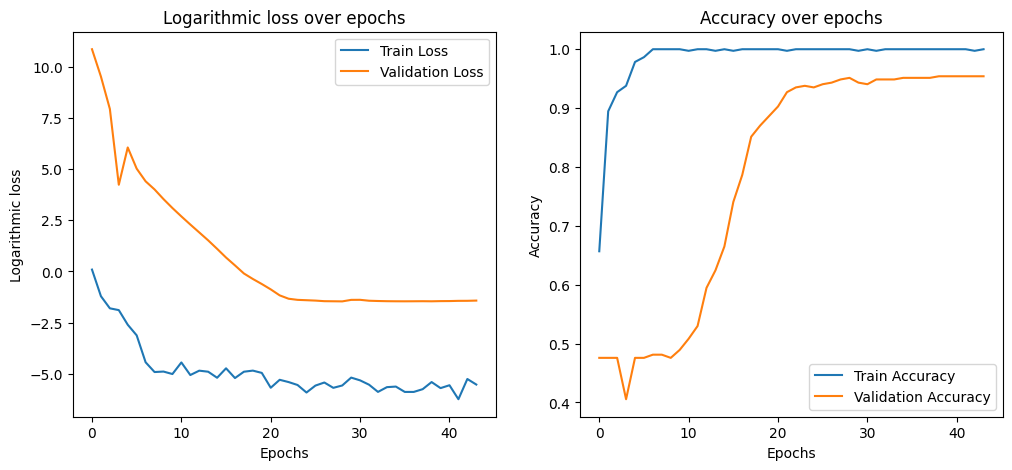

In [34]:
model = define_model(
    input_shape=(150,150,3),
    lr=0.020
)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, verbose=1)
    ],
    verbose=1,
    shuffle=True
)

# Extract loss & accuracy
loss = history.history['loss']
loss = np.log(loss)
val_loss = history.history['val_loss']
val_loss = np.log(val_loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Logarithmic loss")
plt.legend()
plt.title("Logarithmic loss over epochs")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")

plt.show()

# 4 Network Evaluation

## 4.1 Evaluation Metrics

In [35]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred.reshape(-1) >= 0.5).astype(int)

# Report the evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
sensitivity = recall_score(y_test, y_pred_classes, average='weighted') # Sensitivity = Recall
specificity = recall_score(y_test, y_pred_classes, average='weighted') # Specificity is (1 - False Positive Rate)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print the classification report (for precision, recall, F1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 481ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Accuracy: 0.9500
Precision: 0.9500
Sensitivity: 0.9500
Specificity: 0.9500
F1 Score: 0.9500


## 4.2 Confusion Matrix

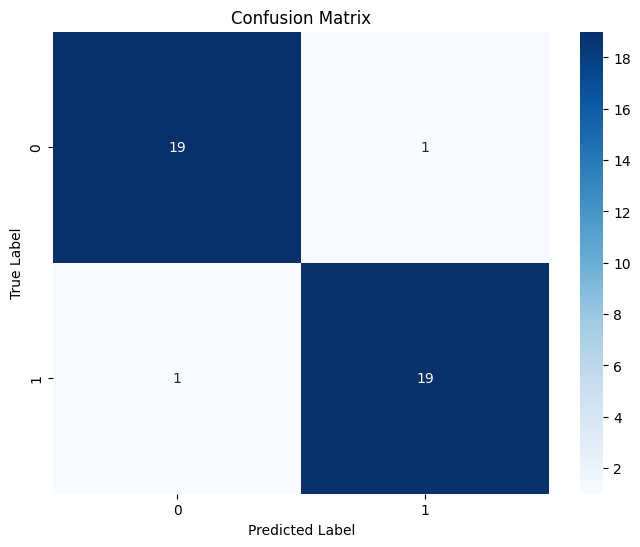

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# All in Once

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 500ms/step - accuracy: 0.7067 - loss: 0.7654 - val_accuracy: 0.4775 - val_loss: 60.1343 - learning_rate: 0.0040
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9218 - loss: 0.2116 - val_accuracy: 0.6126 - val_loss: 5.7718 - learning_rate: 0.0040
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9439 - loss: 0.1339 - val_accuracy: 0.4820 - val_loss: 13.1562 - learning_rate: 0.0040
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9661 - loss: 0.0766 - val_accuracy: 0.4775 - val_loss: 10.7406 - learning_rate: 0.0040
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9859 - loss: 0.0346 - val_accuracy: 0.4775 - val_loss: 8.9596 - learning_rate: 0.0040
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9807 - loss: 0.0382 - val_accuracy: 0.4775 - val_loss: 11.2367 - learning_rate: 0.0040
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9922 - loss: 0.0

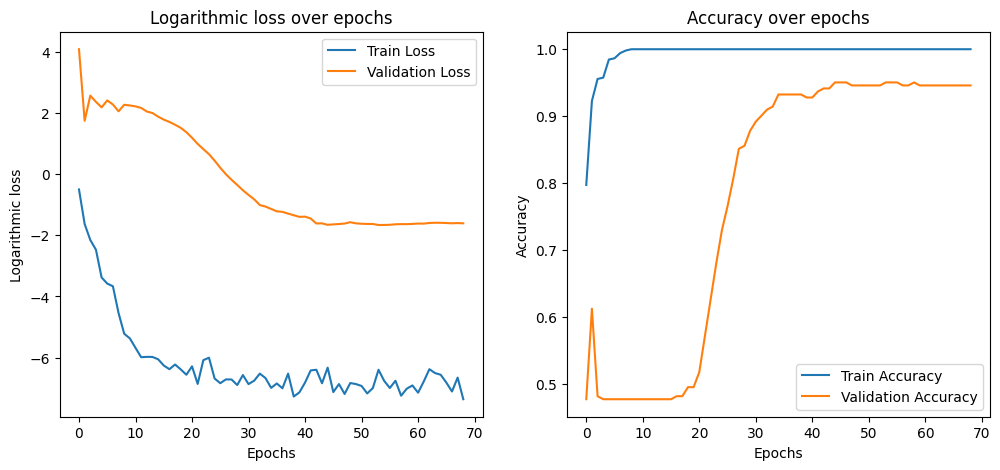

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.74      1.00      0.85        20

    accuracy                           0.82        40
   macro avg       0.87      0.82      0.82        40
weighted avg       0.87      0.82      0.82        40

Accuracy: 0.8250
Precision: 0.8704
Sensitivity: 0.8250
Specificity: 0.8250
F1 Score: 0.8195


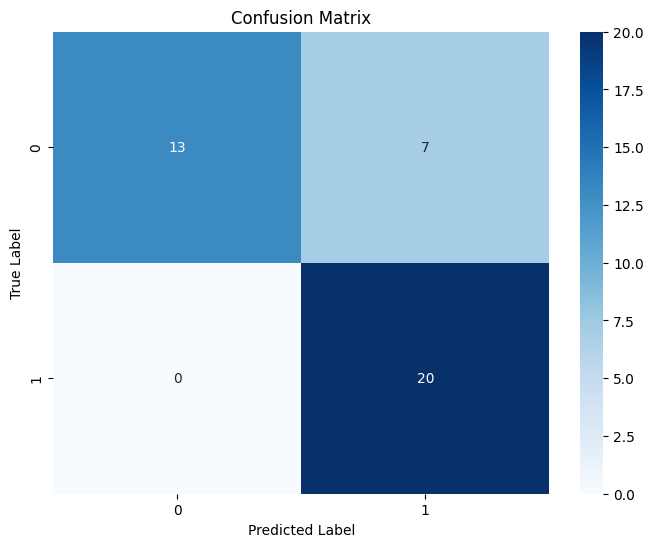

In [54]:
lr = 0.004
batch_size = 26
lr_factor_reduce = 0.2
lr_patience_reduce = 7
test_size = 0.3
epochs = 100


X_train_flipped = np.flip(X_train, axis=2)
X_train_rotated_90 = np.rot90(X_train, k=1, axes=(1,2))
X_train_rotated_180 = np.rot90(X_train, k=2, axes=(1,2))
X_train_rotated_270 = np.rot90(X_train, k=3, axes=(1,2))

X_train_augmented = np.concatenate((X_train, X_train_flipped, X_train_rotated_90, X_train_rotated_180, X_train_rotated_270), axis=0)
y_train_augmented = np.concatenate((y_train, y_train, y_train, y_train, y_train), axis=0)

indices = np.arange(X_train_augmented.shape[0])
np.random.shuffle(indices)
X_train_augmented = X_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

# Split the data into training (80%) and validation (20%) sets
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_augmented, y_train_augmented, test_size=test_size, random_state=33)

model = define_model(
    input_shape=(150,150,3),
    lr=lr
)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=lr_factor_reduce, patience=lr_patience_reduce, verbose=1)
    ],
    verbose=1,
    shuffle=True
)

# Extract loss & accuracy
loss = history.history['loss']
loss = np.log(loss)
val_loss = history.history['val_loss']
val_loss = np.log(val_loss)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Logarithmic loss")
plt.legend()
plt.title("Logarithmic loss over epochs")

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")

plt.show()

y_pred = model.predict(X_test)
y_pred_classes = (y_pred.reshape(-1) >= 0.5).astype(int)

# Report the evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
sensitivity = recall_score(y_test, y_pred_classes, average='weighted') # Sensitivity = Recall
specificity = recall_score(y_test, y_pred_classes, average='weighted') # Specificity is (1 - False Positive Rate)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print the classification report (for precision, recall, F1)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()